# Import Needed Libraries

In [1]:
import numpy as np
import pandas as pd
import os 
import tensorflow as tf

In [2]:
import tensorflow.keras as keras
from keras import Model
from keras.applications import DenseNet121
from keras.preprocessing import image

In [3]:
from keras.applications.densenet import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
from keras.utils import plot_model
import matplotlib.pyplot as plt

In [4]:
import matplotlib.image as mpimg
import cv2
import pathlib
from sklearn.metrics.pairwise import linear_kernel

# Load Database

In [87]:
path = 'C:\\Fashion Product Images Dataset\\fashion-dataset\\fashion-dataset'


In [88]:
dataset_path = pathlib.Path(path)
images=os.listdir(dataset_path)


In [89]:
images

['images', 'images.csv', 'styles', 'styles.csv']

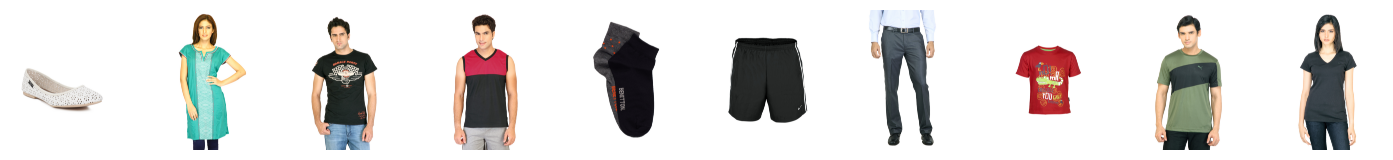

In [90]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Initialize the figure with a specific size
plt.figure(figsize=(20, 20))

# Loop through the specified range
for i in range(10, 20):
    # Create a subplot in a 6x10 grid
    plt.subplot(6, 10, i - 10 + 1)
    
    # Construct the file path using os.path.join
    file_name = f"{i}613.jpg"
    file_path = os.path.join(path, 'images', file_name)
    
    # Read and display the image
    cloth_img = mpimg.imread(file_path)
    plt.imshow(cloth_img)
    plt.axis("off")  # Turn off the axis
    
# Adjust spacing between subplots
plt.subplots_adjust(wspace=-0.5, hspace=1)

# Display the figure
plt.show()


In [91]:
df = pd.read_csv(path + "\\styles.csv", nrows=6000)
df['image'] = df.apply(lambda x: str(x['id']) + ".jpg", axis=1)
df = df.reset_index(drop=True)
print(df.shape)
df.head(5)

(6000, 11)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,53759.jpg


In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  6000 non-null   int64 
 1   gender              6000 non-null   object
 2   masterCategory      6000 non-null   object
 3   subCategory         6000 non-null   object
 4   articleType         6000 non-null   object
 5   baseColour          6000 non-null   object
 6   season              5998 non-null   object
 7   year                6000 non-null   int64 
 8   usage               5946 non-null   object
 9   productDisplayName  5999 non-null   object
 10  image               6000 non-null   object
dtypes: int64(2), object(9)
memory usage: 515.8+ KB


# Prepare Model

In [10]:
#image dim
img_width, img_height, chnl = 200, 200, 3

# DenseNet121
densenet = DenseNet121(include_top=False, weights='imagenet', input_shape=(img_width, img_height, chnl))
densenet.trainable = False

# Add Layer Embedding
model = keras.Sequential([
    densenet,
    GlobalMaxPooling2D()
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 6, 6, 1024)        7037504   
                                                                 
 global_max_pooling2d (Glob  (None, 1024)              0         
 alMaxPooling2D)                                                 
                                                                 
Total params: 7037504 (26.85 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 7037504 (26.85 MB)
_________________________________________________________________


In [11]:
def model_predict_batch(model, img_names, target_size):
    imgs = []
    for img_name in img_names:
        img = resize_image(img_name, target_size)  # Resizing the image
        x = image.img_to_array(img)
        imgs.append(x)
    
    x_batch = np.array(imgs)  # Convert list to a batch (NumPy array)
    x_batch = preprocess_input(x_batch)
    return model.predict(x_batch)


In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tqdm import tqdm  # Progress bar for large loops
from concurrent.futures import ThreadPoolExecutor

# Assuming these variables are defined elsewhere
# model, img_width, img_height, path, preprocess_input

def img_path(img):
    return path + '\\images\\' + img

def resize_image(img_name, target_size):
    img = image.load_img(img_path(img_name))
    img = img.resize(target_size)  # Resize the image to the target size
    return img

def model_predict(model, img_name, target_size):
    img = resize_image(img_name, target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return model.predict(x).reshape(-1)

def process_images_parallel(df, model, num_workers=4, target_size = (200, 200)):
    # Split DataFrame into chunks for parallel processing
    df_split = np.array_split(df, num_workers)
    
    # Function to process each chunk
    def process_chunk(df_chunk):
        df_chunk['embedding'] = df_chunk['image'].apply(lambda x: model_predict(model, x, target_size))
        return df_chunk

    # Use ThreadPoolExecutor to parallelize
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        df_chunks = list(tqdm(executor.map(process_chunk, df_split), total=len(df_split)))

    # Combine all chunks back into a single DataFrame
    return pd.concat(df_chunks, axis=0)

# Applying the parallel processing to get embeddings with resized images
target_size = (200, 200)  # Define a smaller target size to reduce processing time
df_embedding = process_images_parallel(df, model, num_workers=8, target_size=target_size)  # Adjust num_workers based on your CPU/GPU

# Split embeddings into separate columns
df_embedding_final = pd.DataFrame(df_embedding['embedding'].tolist(), index=df_embedding.index)

# Show the first 5 embeddings
df_embedding_final.head(5)


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 1s 503ms/step


100%|██████████| 8/8 [42:28<00:00, 318.53s/it]   


,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.003049,0.009359,0.017535,0.015788,0.261184,1.310446,0.001342,0.008973,0.828029,0.001683,...,0.733133,0.014344,5.706058,0.045160,0.186068,2.127871,3.742461,0.529577,8.334532,4.566957
1,0.000838,0.018187,0.014101,0.028162,0.255729,1.004628,0.001287,0.008444,0.528791,0.001195,...,1.893086,1.738379,10.660961,0.297724,0.451555,2.393119,0.481814,1.231735,4.153381,0.724365
2,0.001235,0.008133,0.010047,0.007049,0.407508,1.401649,0.003090,0.003609,0.655068,0.001413,...,5.118924,0.664252,2.446575,1.063173,1.796283,0.686526,2.673178,6.049944,12.941051,0.911145
3,0.001433,0.015174,0.022432,0.017517,0.272663,3.221761,0.001338,0.011005,0.472250,0.001948,...,0.886214,1.812620,10.585509,1.975083,0.226796,6.040342,0.128762,0.606352,6.940913,1.186959
4,0.001717,0.011221,0.013819,0.019155,0.366372,1.719933,0.001028,0.008719,0.510867,0.000958,...,0.757620,2.610686,11.685461,1.053109,1.096814,3.533028,1.416583,6.043394,7.134803,0.997672


In [13]:
print(df_embedding.dtypes)  # Print the data types of all columns
#print(df_embedding.head())  # Print the first few rows of the DataFrame to inspect its contents


id                     int64
gender                object
masterCategory        object
subCategory           object
articleType           object
baseColour            object
season                object
year                   int64
usage                 object
productDisplayName    object
image                 object
embedding             object
dtype: object


In [14]:
print(df_embedding.shape)

(6000, 12)


In [15]:
# Assuming 'embedding' column is split and numerical
df_embedding_numeric = pd.DataFrame(df_embedding['embedding'].tolist(), index=df_embedding.index)
print(df_embedding_numeric)

          0         1         2         3         4         5         6     \
0     0.003049  0.009359  0.017535  0.015788  0.261184  1.310446  0.001342   
1     0.000838  0.018187  0.014101  0.028162  0.255729  1.004628  0.001287   
2     0.001235  0.008133  0.010047  0.007049  0.407508  1.401649  0.003090   
3     0.001433  0.015174  0.022432  0.017517  0.272663  3.221761  0.001338   
4     0.001717  0.011221  0.013819  0.019155  0.366372  1.719933  0.001028   
...        ...       ...       ...       ...       ...       ...       ...   
5995  0.001350  0.041669  0.006245  0.007277  0.451283  1.276101  0.003019   
5996  0.002708  0.020225  0.008812  0.007602  0.427343  2.585837  0.002910   
5997  0.001071  0.009584  0.008425  0.009260  0.257519  1.518844  0.001351   
5998  0.001095  0.018645  0.017541  0.014143  0.304310  2.578079  0.001082   
5999  0.000650  0.017123  0.006471  0.007475  0.535570  1.581053  0.001824   

          7         8         9     ...      1014      1015    

In [23]:
df_embedding_clean = df_embedding_numeric.select_dtypes(include=[np.number])

In [24]:
cosine_sim = linear_kernel(df_embedding_clean, df_embedding_clean)

In [25]:
indices = pd.Series(range(len(df)), index=df.index)

In [26]:
def get_index_from_path(image_path, df):
    image_name = os.path.basename(image_path)
    index = df[df['image'] == image_name].index[0]
    return index

In [27]:
def get_recommendations_from_path(image_path, df, cosine_sim):
    index = get_index_from_path(image_path, df)
    idx = indices[index]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]
    cloth_indices = [i[0] for i in sim_scores]
    return df['image'].iloc[cloth_indices]

# Input as Path

In [28]:
chosen_img_path = os.path.join(path, 'images', 'C:\\Fashion Product Images Dataset\\fashion-dataset\\images\\58641.jpg')  

In [51]:
df['image'] = df['image'].str.strip()

Looking for image: 29114.jpg
Sample image names in DataFrame:
0     15970.jpg
1     39386.jpg
2     59263.jpg
3     21379.jpg
4     53759.jpg
5      1855.jpg
6     30805.jpg
7     26960.jpg
8     29114.jpg
9     30039.jpg
10     9204.jpg
11    48123.jpg
12    18653.jpg
13    47957.jpg
14    46885.jpg
Name: image, dtype: object
Found index: 8


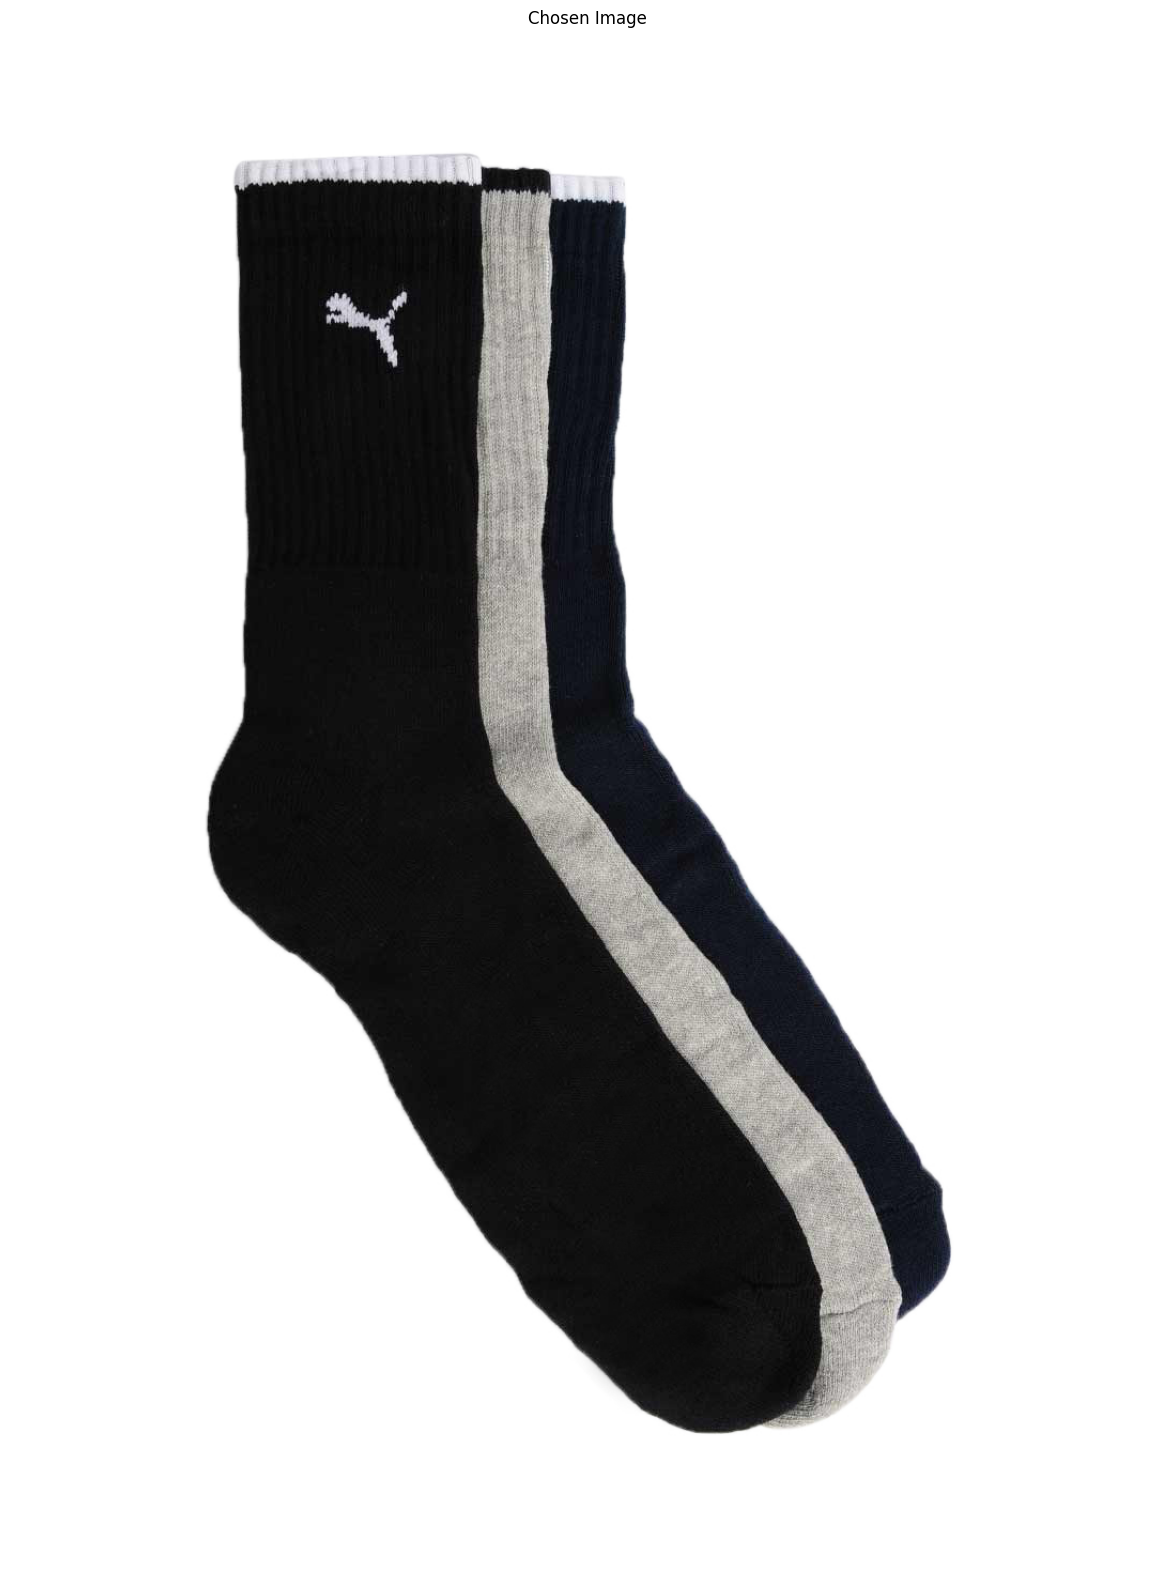

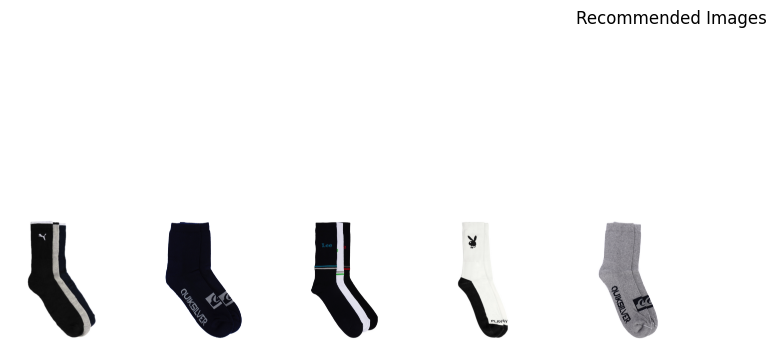

In [68]:
import os

def get_index_from_path(image_path, df):
    image_name = os.path.basename(image_path)
    # Strip any leading/trailing spaces from filenames
    image_name = image_name.strip()
    print(f"Looking for image: {image_name}")
    print("Sample image names in DataFrame:")
    print(df['image'].head(15))
    
    matched_indices = df[df['image'].str.strip() == image_name].index
    if not matched_indices.empty:
        index = matched_indices[0]
        print(f"Found index: {index}")
        return index
    else:
        print(f"Image {image_name} not found in DataFrame.")
        return None

def get_recommendations_from_path(image_path, df, cosine_sim):
    index = get_index_from_path(image_path, df)
    if index is not None:
        idx = indices[index]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:6]
        cloth_indices = [i[0] for i in sim_scores]
        return df['image'].iloc[cloth_indices]
    else:
        return pd.Series([])  # Return an empty Series if the image was not found

# Path of the chosen image
chosen_img_path = os.path.join(path, 'images', 'C:\\Fashion Product Images Dataset\\fashion-dataset\\images\\29114.jpg')  # Update with your image path

# Get recommendations based on the image path
recommendation = get_recommendations_from_path(chosen_img_path, df, cosine_sim)
recommendation_list = recommendation.to_list()

# Display the chosen image
chosen_img = mpimg.imread(chosen_img_path)
plt.figure(figsize=(20, 20))
plt.subplot(1, 1, 1)
plt.title("Chosen Image")
plt.imshow(chosen_img)
plt.axis("off")

# Display the recommended images
if not recommendation_list:
    print("No recommendations found.")
else:
    plt.figure(figsize=(20, 20))
    for j, img_name in enumerate(recommendation_list):
        plt.subplot(6, 10, j + 1)
        cloth_img_path = os.path.join(path, 'images', img_name)
        cloth_img = mpimg.imread(cloth_img_path)
        plt.imshow(cloth_img)
        plt.axis("off")
    plt.suptitle("Recommended Images")
    plt.subplots_adjust(wspace=-0.5, hspace=1)
    plt.show()


# Input as Index

In [57]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(df_embedding_numeric, df_embedding_numeric)
print(cosine_sim.shape)
print(cosine_sim[:5, :5])
print(df_embedding_numeric.shape) 


(6000, 6000)
[[ 6566.1025  5116.402   4462.29    4779.8345  6344.8525]
 [ 5116.402   6720.328   3988.7686  5533.1587  5455.695 ]
 [ 4462.29    3988.7686 11737.84    4239.6694  5287.826 ]
 [ 4779.8345  5533.1587  4239.6694  6148.408   5471.66  ]
 [ 6344.8525  5455.695   5287.826   5471.66    8301.879 ]]
(6000, 1024)


In [58]:
df_embedding_clean = df_embedding_numeric.select_dtypes(include=[np.number])
cosine_sim = linear_kernel(df_embedding_clean, df_embedding_clean)
print(df_embedding_clean)

          0         1         2         3         4         5         6     \
0     0.003049  0.009359  0.017535  0.015788  0.261184  1.310446  0.001342   
1     0.000838  0.018187  0.014101  0.028162  0.255729  1.004628  0.001287   
2     0.001235  0.008133  0.010047  0.007049  0.407508  1.401649  0.003090   
3     0.001433  0.015174  0.022432  0.017517  0.272663  3.221761  0.001338   
4     0.001717  0.011221  0.013819  0.019155  0.366372  1.719933  0.001028   
...        ...       ...       ...       ...       ...       ...       ...   
5995  0.001350  0.041669  0.006245  0.007277  0.451283  1.276101  0.003019   
5996  0.002708  0.020225  0.008812  0.007602  0.427343  2.585837  0.002910   
5997  0.001071  0.009584  0.008425  0.009260  0.257519  1.518844  0.001351   
5998  0.001095  0.018645  0.017541  0.014143  0.304310  2.578079  0.001082   
5999  0.000650  0.017123  0.006471  0.007475  0.535570  1.581053  0.001824   

          7         8         9     ...      1014      1015    

In [59]:
indices = pd.Series(range(len(df)), index=df.index)


In [60]:
def get_recommendations(index, df, cosine_sim=cosine_sim):
    idx = indices[index]

    # Get the pairwsie similarity scores of all clothes with that one
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the clothes based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 5 most similar clothes
    sim_scores = sim_scores[1:6]

    # Get the clothes indices
    cloth_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df['image'].iloc[cloth_indices]

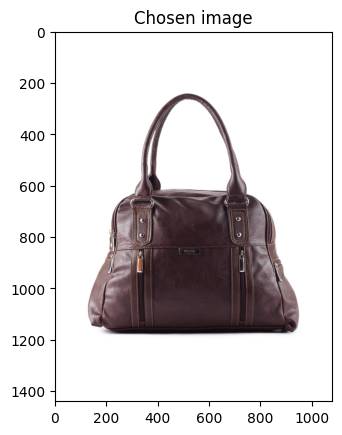

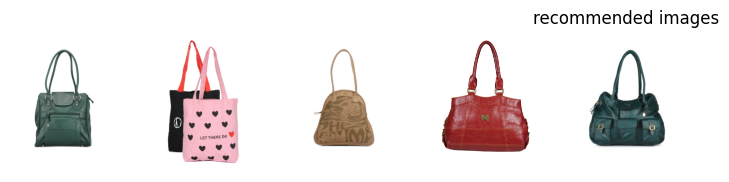

In [62]:

chosen_img_indx = 186


recommendation = get_recommendations(chosen_img_indx, df, cosine_sim)
recommendation_list = recommendation.to_list()
#chosen image
chosen_img =  mpimg.imread(path +  '\\images\\' + df.iloc[chosen_img_indx].image)
plt.title("Chosen image")
plt.imshow(chosen_img)
#recommended images
plt.figure(figsize=(20,20))
j=0
for i in recommendation_list:
    plt.subplot(6, 10, j+1)
    cloth_img =  mpimg.imread(path +  '\\images\\'+ i)
    plt.imshow(cloth_img)
    plt.axis("off")
    j+=1
plt.title("recommended images")
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()

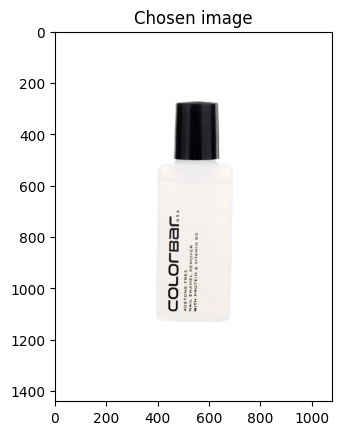

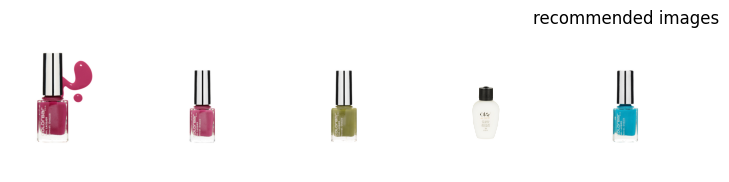

In [64]:
chosen_img_indx = 2807

recommendation = get_recommendations(chosen_img_indx, df, cosine_sim)
recommendation_list = recommendation.to_list()
#chosen image
chosen_img =  mpimg.imread(path + '\\images\\' + df.iloc[chosen_img_indx].image)
plt.title("Chosen image")
plt.imshow(chosen_img)
#recommended images
plt.figure(figsize=(20,20))
j=0
for i in recommendation_list:
    plt.subplot(6, 10, j+1)
    cloth_img =  mpimg.imread(path + '\\images\\'+ i)
    plt.imshow(cloth_img)
    plt.axis("off")
    j+=1
plt.title("recommended images")
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()